### Test - Synthetic Diagnostic + Interferometry

</b> Author:   </b>  Louis Evans     </br>
</b> Reviewer: </b>  Stefano Merlini

### Import relevant files:

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import vtk
from vtk.util import numpy_support as vtk_np
import matplotlib.pyplot as plt

import sys

#add path
sys.path.insert(0, '../../synthPy_restructured')     # import path/to/synthpy

import beam as beam_initialiser
import diagnostics as diag
import domain as d
import propagator as p
#import propagator_backup_non_jax as p
import utils

import importlib
importlib.reload(beam_initialiser)
importlib.reload(diag)
importlib.reload(d)
importlib.reload(p)
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\samma\\programming\\synthPy\\examples\\notebooks\\../../synthPy_restructured\\utils.py'>

To use the ray tracer, first create a 'domain', load the domain with an electron distribution, calculate electron gradients, initialise a beam, and solve!
\
\
The output can either be plotted, or passed further through ray optics for synthetic diagnostics

In [146]:
# define some extent, the domain should be distributed as +extent to -extent, does not need to be cubic
extent_x = 5e-3
extent_y = 5e-3
extent_z = 10e-3

n_cells = 1000

x = np.linspace(-extent_x, extent_x, n_cells)
y = np.linspace(-extent_y, extent_y, n_cells)
z = np.linspace(-extent_z, extent_z, n_cells)

probing_extent = extent_z
probing_direction = 'z'

lengths = 2 * np.array([extent_x, extent_y, extent_z])

#domain = d.ScalarDomain(x = x, y = y, z = z, extent= probing_extent, probing_direction = probing_direction)     # create domain
# Much simpler domain function, no longer needlessly takes in beam values, they are fully seperated
domain = d.ScalarDomain(lengths, n_cells) # B_on = False by default

Load some domain distribution

In [147]:
# load some external pvti
# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)
# or load a test distribution

domain.test_exponential_cos()

Solve gradients, initialise beam, and solve

In [ ]:
wl = 1064e-9 #define laser wavelength

# initialise beam
#Np = 100000    # number of photons
Np = 1000 # small test case for new diffrax solver
divergence = 5e-5   # realistic divergence value
beam_size = extent_x    # beam radius
ne_extent = probing_extent  # so the beam knows where to initialise initial positions
beam_type = 'circular'

initial_rays = beam_initialiser.Beam(Np, beam_size, divergence, ne_extent, probing_direction, wl, beam_type)

tracer = p.Propagator(domain, initial_rays, inv_brems = False, phaseshift = False)


'''
# solve ray trace
tracer.calc_dndr()
print("Completed calc_dndr routine.")

final_rays = tracer.solve(parallelise = False)
#final_rays, final_rays_to_Jonesvector = tracer.Beam.rf, tracer.Beam.Jf
print("Completed ray trace in", np.round(tracer.duration, 3), "seconds.")



tracer_parallelised_jitted = p.Propagator(domain, initial_rays, inv_brems = False, phaseshift = False)

# solve ray trace
tracer_parallelised_jitted.calc_dndr()
print("Completed calc_dndr routine.")

final_rays_parallelised_jitted = tracer_parallelised_jitted.solve()
print("Completed parallelised & jitted ray trace in", np.round(tracer_parallelised_jitted.duration, 3), "seconds.")
'''


tracer_parallelised = p.Propagator(domain, initial_rays, inv_brems = False, phaseshift = False)

# solve ray trace
tracer_parallelised.calc_dndr()
print("Completed calc_dndr routine.")

final_rays_parallelised = tracer_parallelised.solve(jitted = False)
print("Completed parallelised ray trace in", np.round(tracer_parallelised.duration, 3), "seconds.")

Completed calc_dndr routine.


Pass through ray optics: For Shadowgaphy, Schlieren, or Refractometry:

In [ ]:
#in the diagnostic initialisation, details on the lens configurations, and detector dimensions can be specified
refractometer = diag.Refractometry(tracer.Beam)
refractometer.incoherent_solve()
refractometer.histogram(bin_scale = 1, clear_mem = True)

shadowgrapher = diag.Shadowgraphy(tracer.Beam)
shadowgrapher.single_lens_solve()
shadowgrapher.histogram(bin_scale = 1, clear_mem = True)

schlierener = diag.Schlieren(tracer.Beam)
schlierener.DF_solve()
schlierener.histogram(bin_scale = 1, clear_mem = True)

#information accessed by .H(istogram) , e.g plt.imshow(refractometer.H)


r0 after clearing nan's: (9, 9)

r0 after clearing nan's: (9, 9)

r0 after clearing nan's: (9, 9)


c:\Users\samma\programming\synthPy\examples\notebooks\../../synthPy_restructured\diagnostics.py:82: RuntimeWarning: invalid value encountered in matmul
  return np.matmul(L, r)


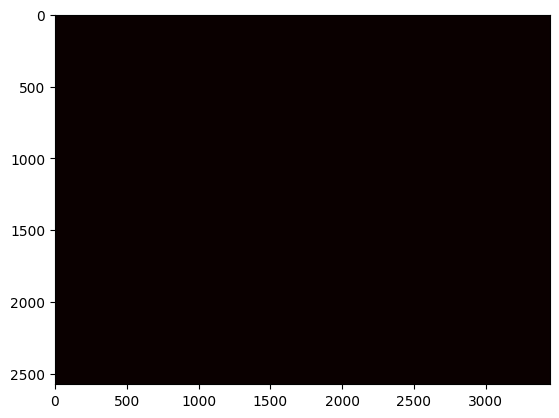

In [ ]:
#plt.imshow(refractometer.H, cmap='hot', interpolation='nearest', clim = (0, 2))
plt.imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

Synthetic Interferometry - This requires some extra steps in the ray tracing to include information on the phase and electric field values

In [ ]:
# No need to change the domain (now that code has been seperated out in restructure)



# load some external pvti

# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)

# or load a test distribution



# initialise beam



# solve ray trace
tracer = p.Propagator(domain, initial_rays, inv_brems = False, phaseshift = True)

tracer.calc_dndr()

tracer.Beam.rf, tracer.Beam.Jf = tracer.solve(return_E = True)

n_fringes = 10
deg = 10 #adjust number of fringes and tilt in degrees from the vertical exis

interferometrer = diag.Interferometry(tracer.Beam)
interferometrer.interfere_ref_beam(n_fringes, deg)

pattern = diag.Interferometry(tracer.Beam)
#pattern = interferometrer
pattern.two_lens_solve()
pattern.interferogram(bin_scale = 1, clear_mem = True) #use interferogram instead of histogram

#get interferogram histogram with sh.H



Parallelised output has resulting 3D matrix of form: [batch_count, 2, 9]: (10, 2, 9)
	2 to account the start and end results
	9 containing the 3 position and velocity components, amplitude, phase and polarisation

We reshape into the form: (9, 10)


c:\Users\samma\programming\synthPy\examples\notebooks\../../synthPy_restructured\diagnostics.py:415: RuntimeWarning: invalid value encountered in add
  ref_beam = np.exp(2 * n_fringes / 3 * 1.0j * (x_weight * self.rf[0,:] + y_weight * self.rf[2,:]))


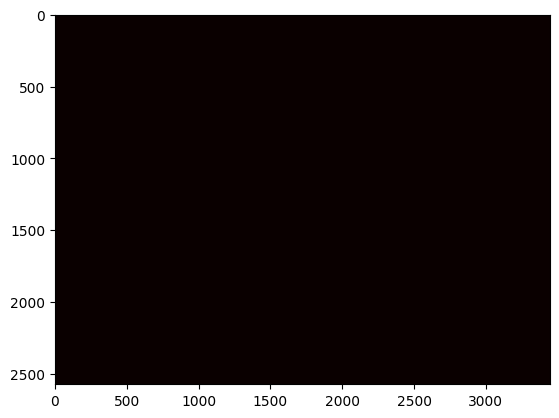

In [ ]:
plt.imshow(pattern.H, cmap = 'hot', interpolation = 'nearest')